In [5]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.integrate import ode
from sympy import Symbol, Point2D, Point3D, Derivative, Function
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Polygon, Circle

In [47]:

class SimPlot:
    fig, ax = None, None

    lines = []
    titles = []
    points = []
    vectors = []
    patches = []

    def __init__(self, xlim, ylim):
        self.fig, self.ax = plt.subplots()
        self.ax.set_xlim(xlim[0], xlim[1])
        self.ax.set_ylim(ylim[0], ylim[1])
        self.ax.set_aspect("equal")

    def plot_lines(self, in_lines, in_colors=[]):
        colors = in_colors + ['black'] * (len(in_lines) - len(in_colors))

        self.lines.extend([
            plt.plot([u[0], v[0]], [u[1], v[1]], color=color)
            for [u, v], color in zip(in_lines, colors)
        ])

    def plot_points(self, in_points, in_sizes=[], in_colors=[]):
        colors = in_colors + ['black'] * (len(in_points) - len(in_colors))
        sizes = in_sizes + [3] * (len(in_points) - len(in_sizes))
        
        self.points.extend([
            plt.plot([x], [y], marker='o', markersize=size, color=color)
            for [x, y], size, color in zip(in_points, sizes, colors)
        ])

    def plot_titles(self, coords, titles, ofx=0, ofy=0):
        self.titles.extend([
            self.ax.text(x + ofx, y + ofy, title)
            for [x, y], title in zip(coords, titles)
        ])

    def plot_vectors(self, vectors_u, vectors_v, titles, scale=1, in_colors=[]):
        colors = in_colors + ['black'] * (len(vectors_u) - len(in_colors))
        self.vectors.extend([
            plt.quiver(float(u[0]), float(u[1]), float(v[0]), float(v[1]), color=color, scale=scale, angles='xy', units='xy', scale_units='xy')
            for u, v, color in zip(vectors_u, vectors_v, colors)
        ])

        self.plot_titles([u + v / scale for u, v in zip(vectors_u, vectors_v)], titles)

    def add_patch(self, patch):
        self.ax.add_patch(patch)
        self.patches.append(patch)
    

    def clear_plot(self):
        while len(self.lines):
            self.lines[-1][0].remove()
            self.lines.pop()

        while len(self.titles):
            self.titles[-1].remove()
            self.titles.pop()

        while len(self.points):
            self.points[-1][0].remove()
            self.points.pop()

        while len(self.vectors):
            self.vectors[-1].remove()
            self.vectors.pop()

        while len(self.patches):
            self.patches[-1].remove()
            self.patches.pop()

# Task 1

In [289]:
m = 13.6 / 1000.0
L = 1500
k = 1.3 * 1e-5
v0 = 870
g = 9.8

## 1.1 + 1.2

In [290]:
alpha = Symbol('alpha')
t = Symbol('t')

In [291]:
eq1 = m * L - m * v0 * sp.cos(alpha) * t
eq2 = -1/2 * m * g * t**2 + m * v0 * sp.sin(alpha) * t

In [292]:
sols = np.array(sp.solve([eq1, eq2], [t, alpha])[2:4], dtype=np.float64)
sols

array([[1.72421923e+00, 9.71127247e-03],
       [1.77542648e+02, 1.56108505e+00]])

In [293]:
vertex_time_eq = -m * g * t + m * v0 * sp.sin(alpha)
vertex_time = np.array([
    sp.solve(vertex_time_eq.subs(alpha, sols[0][1]))[0], 
    sp.solve(vertex_time_eq.subs(alpha, sols[1][1]))[0]
], dtype=np.float64)
vertex_time

array([ 0.86210962, 88.77132408])

In [294]:
v_x_eq =  v0 * sp.cos(alpha) * t
v_y_eq = -1/2 * g * t * t + v0 * sp.sin(alpha) * t

h1 = np.array([
    v_x_eq.subs([(t, vertex_time[0]), (alpha, sols[0][1])]),
    v_y_eq.subs([(t, vertex_time[0]), (alpha, sols[0][1])])
], dtype=np.float64)
h2 = np.array([
    v_x_eq.subs([(t, vertex_time[1]), (alpha, sols[1][1])]),
    v_y_eq.subs([(t, vertex_time[1]), (alpha, sols[1][1])])
], dtype=np.float64)
h2

array([  750.        , 38613.70509711])

In [295]:
h2[1]

38613.70509711211

In [296]:
h1[1]

3.641841663376591

In [297]:
plt_time1 = np.linspace(0, sols[0][0], 100)
plt_time2 = np.linspace(0, sols[1][0], 100)

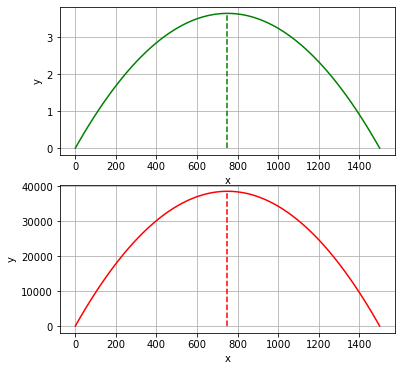

In [298]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.grid(True)
ax2.grid(True)

ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.set_xlabel('x')
ax2.set_ylabel('y')

fig.set_figheight(6)

x1 = []
x2 = []
y1 = []
y2 = []

for i in range(len(plt_time1)):
    x1.append(v_x_eq.subs([(t, plt_time1[i]), (alpha, sols[0][1])]))
    x2.append(v_x_eq.subs([(t, plt_time2[i]), (alpha, sols[1][1])]))

    y1.append(v_y_eq.subs([(t, plt_time1[i]), (alpha, sols[0][1])]))
    y2.append(v_y_eq.subs([(t, plt_time2[i]), (alpha, sols[1][1])]))

ax1.plot(x1, y1, color='green')
ax1.plot([h1[0], h1[0]], [0, h1[1]], color='green', linestyle='--')
ax2.plot(x2, y2, color='red')
ax2.plot([h2[0], h2[0]], [0, h2[1]], color='red', linestyle='--')
plt.rcParams.update({
    "savefig.facecolor": (1.0, 1.0, 1.0, 1)
})
plt.show()

## 1.3

In [244]:
def F(t, s):
    mod_s = np.sqrt(np.dot(s[0:2], s[0:2]))
    r_x = -k / m * mod_s * s[0]
    r_y = -k / m * mod_s * s[1] - g
    return [r_x, r_y, s[0], s[1]]

In [245]:
steps = 1000
tf = 10
dt = 0.02

In [259]:
candidates = []
c_times = []

for alpha in np.linspace(0, np.pi / 2, steps):
    s0 = v0 * np.array([np.cos(alpha), np.sin(alpha)])
    solver = ode(F).set_integrator('lsoda')
    solver.set_initial_value([s0[0], s0[1], 0, 0], 0)
    t_end_t = 0
    while solver.successful() and solver.t < tf:
        s_x, s_y, x_x, x_y = solver.integrate(solver.t + dt)
        t_end_t += dt
        if np.abs(x_x - L) < 5 and np.abs(x_y) < 5:
            candidates.append(alpha)
            c_times.append(t_end_t)
            break
        if x_x > L:
            break
        if x_y < 0:
            break


In [260]:
candidates

[0.03301974260529812, 0.034592111300788514]

In [261]:
sol_angle = candidates[0]
t_end = c_times[0]

In [299]:
t_end

3.840000000000003

In [271]:
x_pos = []
y_pos = []

vs = []

h_x = 0
h_y = 0
min_v_y = v0
f_c_t = [[0, 0]]
t_max = 0

s0 = v0 * np.array([np.cos(sol_angle), np.sin(sol_angle)])
pos = np.array([0, 0], dtype=np.float64)
solver = ode(F).set_integrator('lsoda')
solver.set_initial_value([s0[0], s0[1], 0, 0], 0)

while solver.successful() and solver.t < t_end and pos[1] >= 0 and pos[0] < L:
    s_x, s_y, x_x, x_y = solver.integrate(solver.t + dt)
    x_pos.append(x_x)
    y_pos.append(x_y)
    vs.append([s_x, s_y])
    f_c_t.append([-k * v0 * s_x, -k * v0 * s_y])
    
    if s_y < min_v_y and s_y >= 0:
        h_x, h_y = x_x, x_y
        min_v_y = s_y

    


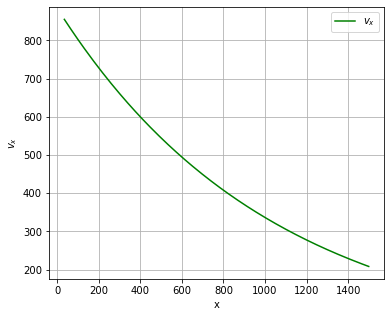

In [287]:
fig, ax1 = plt.subplots()

fig.set_figheight(5)

ax1.set_xlabel('x')
ax1.set_ylabel(r'$v_x$')
ax1.grid(True)

ax1.plot(x_pos[1:], [x for x, y in vs[:-1]], color='green', label=r'$v_x$')
plt.legend()
plt.rcParams.update({
    "savefig.facecolor": (1.0, 1.0, 1.0, 1)
})
plt.savefig('assets/t1vplot.png', dpi=300)

In [300]:
h_y

19.581256539958225

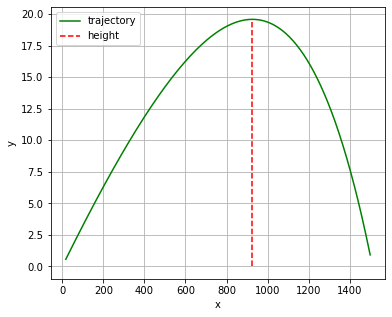

In [283]:
fig, ax1 = plt.subplots()

fig.set_figheight(5)
ax1.grid(True)
ax1.plot(x_pos, y_pos, color='green', label='trajectory')
ax1.plot([h_x, h_x], [0, h_y], color='red', linestyle='--', label='height')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
plt.rcParams.update({
    "savefig.facecolor": (1.0, 1.0, 1.0, 1)
})
plt.legend()
plt.show()

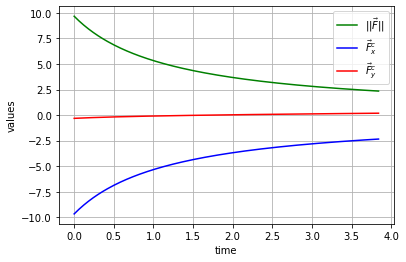

In [286]:
fig, ax1 = plt.subplots()

ax1.plot(np.linspace(0, t_end, int(t_end / dt)), [np.sqrt(x**2 + y**2) for x, y in f_c_t[1:]], color='green', label=r'$\|\|\vec{F}\|\|$')
ax1.plot(np.linspace(0, t_end, int(t_end / dt)), [x for x, y in f_c_t[1:]], color='blue', label=r'$\vec{F}^c_x$')
ax1.plot(np.linspace(0, t_end, int(t_end / dt)), [y for x, y in f_c_t[1:]], color='red', label=r'$\vec{F}^c_y$')

ax1.set_xlabel('time')
ax1.set_ylabel('values')
plt.grid(True)
plt.legend()
plt.rcParams.update({
    "savefig.facecolor": (1.0, 1.0, 1.0, 1)
})
plt.show()

# Task 2

In [6]:
m = 0.02
omega = np.pi
r = 0.5
g = 9.8

t0 = 0
x0 = 0
dx0 = 0.4

In [7]:
t = Symbol('t')
X = Function('X')(t)
dX = Derivative(X)
ddX = Derivative(dX)

In [9]:
eq = m * omega**2 * X + m * g * sp.sin(omega * t) - m * ddX
eq

0.197392088021787*X(t) + 0.196*sin(3.14159265358979*t) - 0.02*Derivative(X(t), (t, 2))

Let's imagine I have done it analytcally or via the sympy (Wolfram in reality)

![](assets/t2ode.PNG)

In [36]:
X = 0.312 * sp.exp(-sp.pi * t) * (-1 + 1 * sp.exp(2 * sp.pi * t) - 1.5917 * sp.exp(sp.pi * t) * sp.sin(sp.pi * t))
X

0.312*(exp(2*pi*t) - 1.5917*exp(pi*t)*sin(pi*t) - 1)*exp(-pi*t)

In [37]:
dX = Derivative(X)
dX

Derivative(0.312*(exp(2*pi*t) - 1.5917*exp(pi*t)*sin(pi*t) - 1)*exp(-pi*t), t)

In [125]:
N = m * g * sp.cos(omega * t) - 2 * m * omega * dX
N

0.196*cos(3.14159265358979*t) - 0.125663706143592*Derivative(0.312*(exp(2*pi*t) - 1.5917*exp(pi*t)*sin(pi*t) - 1)*exp(-pi*t), t)

Let's find time when the ball leaves the channel

![](assets/t2time.PNG)

In [126]:
t_end = 0.388943
t_end

0.388943

In [127]:
steps = 100

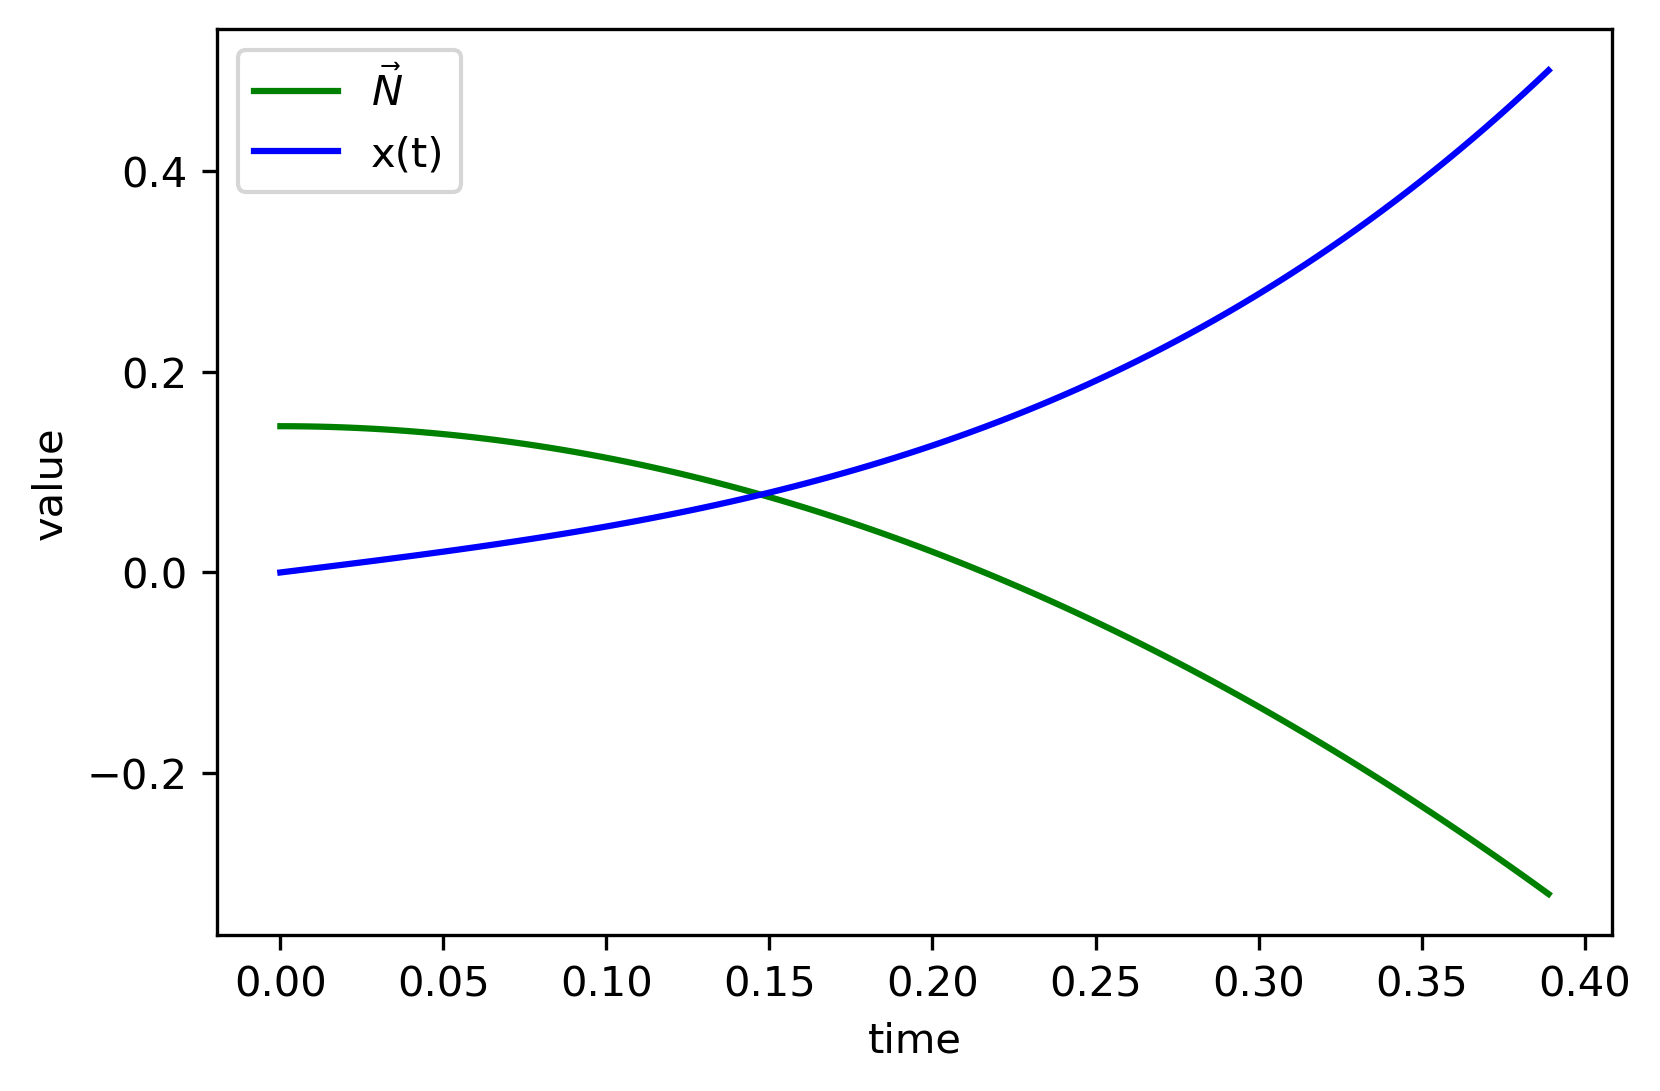

In [143]:
fig, ax = plt.subplots()

t_frames = np.linspace(0, t_end, steps)
n_frames = [float(N.subs(t, frame).evalf().doit()) for frame in t_frames]
x_frames = [float(X.subs(t, frame).evalf().doit()) for frame in t_frames]

plt.plot(t_frames, n_frames, color='green', label=r'$\vec{N}$')
plt.plot(t_frames, x_frames, color='blue', label=r'x(t)')

plt.gcf().set_dpi(300)
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.rcParams.update({
    "savefig.facecolor": (1.0, 1.0, 1.0, 1)
})
plt.show()

In [144]:
O = Point2D(0, 0)
dalpha = 0.05

K1 = r * Point2D(sp.cos(-omega * t - dalpha), sp.sin(-omega * t - dalpha))
K2 = r * Point2D(sp.cos(-omega * t + dalpha), sp.sin(-omega * t + dalpha))
K3 = r * Point2D(sp.cos(-omega * t - dalpha + np.pi), sp.sin(-omega * t - dalpha + np.pi))
K4 = r * Point2D(sp.cos(-omega * t + dalpha + np.pi), sp.sin(-omega * t + dalpha + np.pi))

M = X * Point2D(sp.cos(-omega * t), sp.sin(-omega * t))


In [145]:
tau = (M - O) / sp.sqrt(np.dot(M - O, M - O))
norm = Point2D(np.dot([tau[0], tau[1], 0], sp.rot_axis3(sp.pi / 2))[0:2])

In [146]:
model = SimPlot([-1, 1], [-1, 1])

model.ax.axis('off')

ln, = plt.plot([], [], 'b--')

def update_anim(frame):

    M_frame = M.subs(t, frame).doit().evalf()

    dX_frame = dX.subs(t, frame).doit().evalf()
    V_frame = dX_frame * tau.subs(t, frame).evalf()

    N_frame = N.subs(t, frame).doit().evalf()
    N_frame = N_frame * norm.subs(t, frame).evalf()

    Phi_cor = 2 * dX_frame * omega * norm.subs(t, frame).evalf()

    channel = [P.subs(t, frame).evalf() for P in [K1, K2, K3, K4]]

    model.clear_plot()
    model.plot_points([O], in_colors=['black'])

    model.plot_lines([
        [channel[0], channel[3]], [channel[1], channel[2]]
    ], in_colors=['black', 'black'])

    model.points.append(
        plt.plot([M_frame[0]], [M_frame[1]], marker='o', markersize=5, color='red')
    )
    
    model.plot_vectors([M_frame], [N_frame], [r'$\vec{N}$'], 1/2, in_colors=['blue'])

    model.plot_vectors([M_frame], [Phi_cor], [r'$\vec{\Phi}^{cor}$'], 40, in_colors=['red'])

    model.plot_vectors([M_frame], [np.array([0, -m * g])], [r'$m\vec{g}$'], 1)
    
    model.add_patch(
        Circle(O, r, color='green', fill=False)
    )

    model.lines.append(
        plt.plot([O[0], M_frame[0]], [O[1], M_frame[1]], color='red', linestyle='--')
    )

    return ln,

frames = np.linspace(0 + 1e-5, t_end, 100)

anim = FuncAnimation(model.fig, update_anim, frames=frames, blit=True)
anim.save('model.gif', dpi=300, writer=PillowWriter(fps=60))
plt.close('all')